Task

Subtask B: Conspiracy Category Classification : a system must discriminate which conspiracy theory a post supports. We consider four possible conspiracies:

In this competition, specific competition participants will tackle the SECOND of these two subtasks.

Covid Conspiracy: It is related to narratives concerning vaccine production, 5G, restrictions, and all kind of news intended to support the idea that the pandemic and actions taken by the government were useless instruments of control of the population.

Qanon Conspiracy: Qanon supported the idea that a group of Satanic Cannibalist sex abusers conspired against former U.S. President Donald Trump during his term of office. This theory extended far over the original scope embodying other beliefs that support (among the others) hate against women and the idea that a powerful elite (led by public figures like Pope Francis, Queen Elizabeth, and Hillary Clinton ) is trying to organize a New World Order.

Flat Earth: It is a theory that claims that Earth is flat. This theory deals also with discussions about UFO.

Pro-Russia Conspiracy: This theory supports the idea that in the Ukraine-Russia war, Ukraine and NATO supported by nazists soldiers hold the responsability of the war.

In [1]:
#%pip install emoji sklearn pandas numpy nltk transformers torch matplotlib seaborn

Documentazioni:
emoji: https://carpedm20.github.io/emoji/docs/

Il dataset presenta una lista di messaggi/post raccolti su vari social, una delle caratteristiche di queste forme di comunicazioni sono le emoticon (o emoji) e la forma del messaggio in se.
Questo significa che un testo che vuole catturare l'attenzione avrà un "titolo" d'impatto e spesso in maiuscolo, in quanto l'attenzione dedicata a questo tipo di contenuti è poca e di carattere transitorio.

Inoltre il dataset presenta una quantità di dati inadatta all'addestramento di un qualsiasi classficatore superabile tramite tecniche di data augmentation, questa caratteristica è intriseca nel problema in quanto i trend [^1] durano molto poco nel tempo e per un sistema di riconoscimento dei contenuti fuorvianti è necessario essere in grado di adattarsi in breve a queste variazioni.

Il dataset ha dimensione eterogenea, il che potrebbe portare a esempi per il transformer dove sono presenti lunghe stringhe di filler.






Di seguito verranno proposte alcune tecniche di preprocessing e di data augmentation


[^1]: Per trend si indica un argomento che cattura l'attenzione del pubblico e che ha orizzonte temporale molto breve, di solito nell'ordine dei giorni.

Per un analisi più approfondita si rimanda al notebook del task A


In questo Task, a differenza dell'altro si è deciso di ignorare le emoticon e la lunghezza dei messaggi in quanto quelle erano differenze che caratterizzavano per lo più l'appartenenza o meno alla teoria, si sono mantenuti gli hashtag in quanto possono essere distintivi per le singole teorie.



In [2]:
#from google.colab import drive

#drive.mount('/content/gdrive')
#root = '/content/gdrive/MyDrive/Colab Notebooks/dataset/'

root = './Dataset/'

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import time
from torch.optim import Adam
from torch import nn
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils import shuffle
import nltk
import matplotlib.pyplot as plt
import emoji
import copy
import pickle

In [4]:
#carica il dataset csv dal file presente in Dataset/subtaskA_train.cvs
dataset = pd.read_csv('Dataset/subtaskB_train.csv',  header=0, names=['text', 'explicit_label', 'label'])

dataset

,text,explicit_label,label
0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon,1
1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid,0
2,L'avete capito che non toglieranno il green pa...,Covid,0
3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta,3
4,"In breve tempo, per accedere a Internet, sarà ...",Qanon,1
...,...,...,...
805,"Incredibile!!!! EMA, Agenzia Europea del Farma...",Covid,0
806,Non ci saranno colloqui di pace con la Russia ...,Russia,2
807,"L'atmosfera è uno ""scudo protettivo"" che avvol...",Terra Piatta,3
808,OTTIMA NOTIZIA! Due ragioni per cui le élite n...,Covid,0


In [5]:
pd.set_option('display.max_colwidth', None)
color1 = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         )
color2 = (0.4, 0.2, 0.2, 0.6)
color3 = (0.6, 0.3, 0.1, 0.7)
color4 = (0.1, 0.5, 0.4, 0.5)
color5 = (0.8, 0.2, 0.3, 0.8)
colors = [color1, color2, color3, color4, color5]


La distribuzione dei dati è abbastanza eterogenea in favore della teoria del complotto covid, probabilmente data la vicinanza temporale con gli eventi. Si sarebbe potuto tentare di omogenizzare tramite aumento dei dati ma si sarebbe rischiato di avere troppi dati inventati contro molti reali, per cui ho deciso di applicare lo stesso trattamento a tutti i dati.

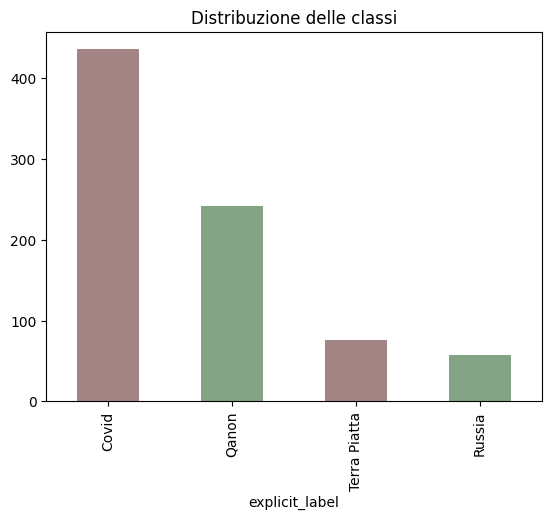

In [6]:
dataset['explicit_label'].value_counts().plot(kind='bar', color=[color2,color1])
plt.title('Distribuzione delle classi')
plt.show()

In [7]:
print("dati mancanti")
print(dataset.isna().sum())

dati mancanti
text              0
explicit_label    0
label             0
dtype: int64


In [8]:
explicit_label_from_index = ["Covid","Qanon","Terra Piatta", "Russia"]

In [9]:
def process_data_augmentation(dataset):
    typeA=['[Sinonimi]:','[Riassunto]:','[Tono diverso]:','[Parole chiave sostituite]:','[Domanda diretta]:']
    typeB=['Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano:','Fornisci un riassunto del testo originale in italiano:','Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano:', 'Sostituisci alcune parole chiave nel testo originale in italiano:','Trasforma il testo originale in una domanda diretta in italiano:']
    processed_dataset = dataset.copy()
    processed_dataset = processed_dataset.drop(columns=['augmented_text'])
    augmented_dataset = pd.DataFrame(columns=['text', 'label'])
    #dataset['augmented_text'] = dataset['augmented_text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

    for i in tqdm(range(len(dataset))):
        #Copio la singola riga del dataset in una variabile per usarla come stringa

        augmented = dataset.loc[i,'augmented_text']
        #Divido la stringa per riga
        augmented = augmented.split('\n')
        #Per ogni riga controllo se è presente una delle stringhe di tipo A o B
        #Esistono due tipi poiché i due modelli restituivano due strutture leggermente diverse
        for statement in augmented:
            #Verifico la riga appartenga al risultato e taglio la parte introduttiva
            for start in typeA:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    #Aggiungo la riga al dataset
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)
            for start in typeB:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)

    processed_dataset['text'] = processed_dataset['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

    return processed_dataset

In [10]:
augmented_dataset = pd.read_csv(f'{root}augmented_dataset2.csv',  header=0, names=['text', 'explicit_label', 'label','augmented_text'])
augmented_dataset = augmented_dataset.drop(columns=['explicit_label'])
augmented_dataset = process_data_augmentation(augmented_dataset)

  0%|          | 0/810 [00:00<?, ?it/s]

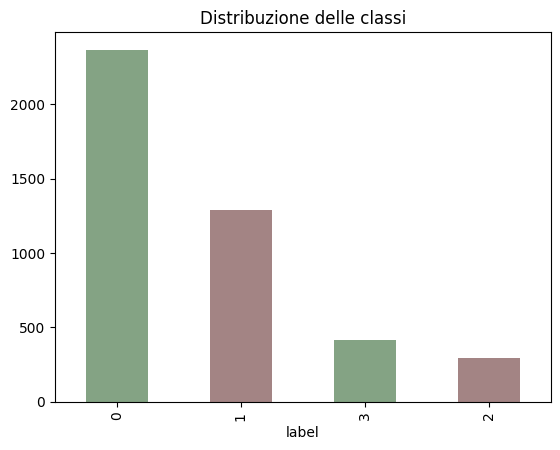

In [11]:
augmented_dataset['label'].value_counts().plot(kind='bar', color=[color1,color2])
plt.title('Distribuzione delle classi')
plt.show()

In [12]:
print("dati mancanti")
print(augmented_dataset.isna().sum())

dati mancanti
text     0
label    0
dtype: int64


In [13]:
augmented_dataset = shuffle(augmented_dataset, random_state=42)
augmented_dataset.head()

,text,label
1374,Il testo originale menziona un rapido resoconto dei piani del Deep State per disturbare l'equilibrio naturale della società e instaurarsi come normale.,1
2293,"CV19, anemia da immunizzazione e RISOLUTIVO universale! Mi lo assumo per altre ragioni e dopo circa sei mesi dirò di aver riscontrato reazioni positive su problematiche e inconvenienti che mi avevo trainato dietro da tempo.",0
3379,"Che azione chiede Luca Teodori, di M3V, riguardo la vaccinazione di massa e quale è la sua opinione sui motivi dietro a essa?",0
1090,Ho attendeva da decenni l'affermazione di questi fenomeni OVNI o OAV... E ho attendeva anche un video così... !!,3
1803,Quale evento è avvenuto il 15 aprile e come è stata descritta tale situazione?,0


In [14]:
def add_hashtag(dataset):
    augmented_dataset = dataset.copy()
    augmented_dataset['hashtag'] = ' '
    data = []

    for i in tqdm(range(len(dataset)), desc= "Looking for hashtag"):
        text = dataset.loc[i,'text']
        dato = [k for k in text.split() if k.startswith("#")]
        data.append(dato)

    augmented_dataset['hashtag'] = data
    augmented_dataset['hashtag'] = augmented_dataset['hashtag'].apply(lambda x: " ".join(x).replace('#', ''))


    return augmented_dataset

In [15]:
augmented_dataset = add_hashtag(augmented_dataset)
augmented_dataset.head()

Looking for hashtag:   0%|          | 0/4368 [00:00<?, ?it/s]

,text,label,hashtag
1374,Il testo originale menziona un rapido resoconto dei piani del Deep State per disturbare l'equilibrio naturale della società e instaurarsi come normale.,1,
2293,"CV19, anemia da immunizzazione e RISOLUTIVO universale! Mi lo assumo per altre ragioni e dopo circa sei mesi dirò di aver riscontrato reazioni positive su problematiche e inconvenienti che mi avevo trainato dietro da tempo.",0,
3379,"Che azione chiede Luca Teodori, di M3V, riguardo la vaccinazione di massa e quale è la sua opinione sui motivi dietro a essa?",0,
1090,Ho attendeva da decenni l'affermazione di questi fenomeni OVNI o OAV... E ho attendeva anche un video così... !!,3,
1803,Quale evento è avvenuto il 15 aprile e come è stata descritta tale situazione?,0,


In [16]:
hyperparameters = {
    "#_classes" : 4,
    "epochs": 30,
    "learning_rate": 1e-6,
    "batch_size": 3,
    "dropout": 0.1,
    "stopwords": False,
    "h_dim": 768,
    "patience": 10,
    "min_delta": 0.01,
    "language_model": "bert-base-multilingual-cased",
    "extra_features": 32, #32 hashtag
}

In [17]:
(x_train, x_test, hashtag_train, hashtag_test,y_train, y_test) = train_test_split(augmented_dataset['text'], augmented_dataset['hashtag'],augmented_dataset['label'], test_size=0.2, random_state=42)

(x_train, x_val, hashtag_train, hashtag_val, y_train, y_val) = train_test_split( x_train,hashtag_train, y_train, test_size=0.1, random_state=42)

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, hashtag, y, stopwords):


        tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]

        text_clean = []

        for sentence in tqdm(tokens_litt, desc='Tokenizing text ... '):
            text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("italian")]))


        self.texts = [text for text in text_clean]
        self.hashtag = [h for h in hashtag]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def get_batch_hashtag(self, idx):
        # Fetch a batch of inputs
        return self.hashtag[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        batch_hashtag = self.get_batch_hashtag(idx)

        return batch_texts, batch_labels, batch_hashtag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
train_dataset = Dataset(x_train,hashtag_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val,hashtag_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test,hashtag_test, y_test, hyperparameters["stopwords"])

Tokenizing text ... :   0%|          | 0/3144 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/350 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/874 [00:00<?, ?it/s]

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping
        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza

In [21]:
class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout, model_name,extra_features = hyperparameters['extra_features']):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)
        self.classifier = nn.Sequential(
            nn.Linear(hdim + extra_features, 512),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(128, labels),
            )

    def forward(self, input_id_text, attention_mask, hashtag):
        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:,0,:]
        output = torch.cat((output, hashtag), dim=1)  # Concatena il conteggio dei caratteri
        return self.classifier(output)

In [22]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels, hashtag in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()
        tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 400, truncation=True)
        tokens_hashtag = tokenizer(list(hashtag), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 32, truncation=True)

        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)

        input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
        mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)
        
        batch_labels = batch_labels.to(device)

        output = model(input_id_texts, mask_texts, input_id_hashtag)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).float().mean()
        
        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()


    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [23]:
def test_loop(model, dataloader, tokenizer, loss, device, best_acc, best_weights):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, hashtag in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                               return_tensors='pt', padding='max_length',
                               max_length = 512, truncation=True)

            tokens_hashtag = tokenizer(list(hashtag), add_special_tokens=True,
                                return_tensors='pt', padding='max_length',
                                max_length = 32, truncation=True)

            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)

            input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
            mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)

            batch_labels = batch_labels.to(device)


            output = model(input_id_texts, mask_texts, input_id_hashtag)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).float().mean()
            

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()
        acc = float(epoch_acc/len(dataloader))
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())


    return epoch_loss/len(dataloader), epoch_acc/len(dataloader), best_acc, best_weights

In [24]:
def train_test(model, epochs, optimizer, device, train_data, test_data,
               batch_size, language_model, train_loss_fn, test_loss_fn=None,
               early_stopping=None, val_data=None, scheduler=None):

  train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    # check sulle funzioni di loss
  if test_loss_fn == None:
    test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
  train_loss = []
  validation_loss = []
  test_loss = []

  train_acc = []
  validation_acc = []
  test_acc = []
  best_acc = - np.inf
  best_weights = None
  tokenizer = AutoTokenizer.from_pretrained(language_model)

    # Ciclo di addestramento con early stopping
  for epoch in tqdm(range(1,epochs+1)):
    epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

        # validation se è presente la callback di early stopping
    if early_stopping != None:
      epoch_validate_loss, epoch_validate_acc, best_acc, best_weights = test_loop(model,
                                val_dataloader, tokenizer, test_loss_fn, device, best_acc, best_weights)
      validation_loss.append(epoch_validate_loss)
      validation_acc.append(epoch_validate_acc)

        # test
    epoch_test_loss, epoch_test_acc, best_acc, best_weights = test_loop(model, test_dataloader, tokenizer, test_loss_fn, device, best_acc, best_weights)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
    val_acc_str = f'Validation accuracy: {(epoch_validate_acc):6.4f} ' if early_stopping != None else ' '
    print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
    print(f"Train accuracy: {(epoch_train_acc):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc):6.4f}")
    # early stopping
    if early_stopping != None:
      early_stopping(epoch_validate_loss)
      if early_stopping.early_stop:
        break

  return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc, best_acc, best_weights

In [25]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")
#La funzione di loss va modificata in base al parametro #_classes
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])

Using cuda device
ClassifierDeep(
  (lm_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [26]:
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc, best_acc, best_weights = train_test(
                                                model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                
                                               )
with open("best_weight.pkl", 'wb') as f:
  pickle.dump(best_weights, f)



  0%|          | 0/30 [00:00<?, ?it/s]

training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 2.0182  Test loss: 2.3348
Train accuracy: 0.4701  Test accuracy: 0.5491


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 1.5896  Test loss: 1.9990
Train accuracy: 0.6858  Test accuracy: 0.8105


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 1.3093  Test loss: 1.9054
Train accuracy: 0.8282  Test accuracy: 0.8345


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.9700  Test loss: 1.8558
Train accuracy: 0.8750  Test accuracy: 0.8470


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 1.0182  Test loss: 1.7546
Train accuracy: 0.9001  Test accuracy: 0.8584


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.8130  Test loss: 1.7031
Train accuracy: 0.9253  Test accuracy: 0.8790


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.9317  Test loss: 1.5930
Train accuracy: 0.9383  Test accuracy: 0.8756


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.6862  Test loss: 1.5232
Train accuracy: 0.9415  Test accuracy: 0.8836


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.6788  Test loss: 1.4896
Train accuracy: 0.9529  Test accuracy: 0.8927


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.5689  Test loss: 1.4772
Train accuracy: 0.9561  Test accuracy: 0.9007


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4128  Test loss: 1.4588
Train accuracy: 0.9593  Test accuracy: 0.9007


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4993  Test loss: 1.4465
Train accuracy: 0.9641  Test accuracy: 0.9087


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4911  Test loss: 1.4791
Train accuracy: 0.9660  Test accuracy: 0.9064


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.5963  Test loss: 1.4667
Train accuracy: 0.9720  Test accuracy: 0.9087


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3631  Test loss: 1.5115
Train accuracy: 0.9730  Test accuracy: 0.9007


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4822  Test loss: 1.4188
Train accuracy: 0.9730  Test accuracy: 0.9087


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.5098  Test loss: 1.3723
Train accuracy: 0.9736  Test accuracy: 0.8984


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2014  Test loss: 1.2966
Train accuracy: 0.9777  Test accuracy: 0.9144


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3059  Test loss: 1.2694
Train accuracy: 0.9781  Test accuracy: 0.8847


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2949  Test loss: 1.2921
Train accuracy: 0.9790  Test accuracy: 0.9110


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3580  Test loss: 1.3565
Train accuracy: 0.9796  Test accuracy: 0.9132


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2719  Test loss: 1.3582
Train accuracy: 0.9793  Test accuracy: 0.9053


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1727  Test loss: 1.2992
Train accuracy: 0.9806  Test accuracy: 0.9155


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1487  Test loss: 1.3412
Train accuracy: 0.9857  Test accuracy: 0.9201


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4517  Test loss: 1.3512
Train accuracy: 0.9841  Test accuracy: 0.9132


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1188  Test loss: 1.3852
Train accuracy: 0.9831  Test accuracy: 0.9132


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1018  Test loss: 1.3770
Train accuracy: 0.9841  Test accuracy: 0.9075


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1540  Test loss: 1.4972
Train accuracy: 0.9822  Test accuracy: 0.9041


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3034  Test loss: 1.4099
Train accuracy: 0.9844  Test accuracy: 0.9167


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1764  Test loss: 1.3849
Train accuracy: 0.9825  Test accuracy: 0.9098


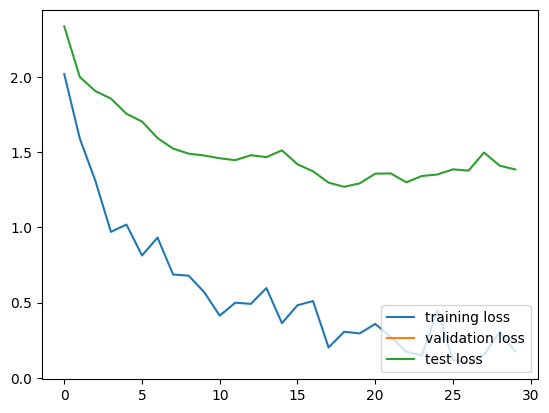

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.show()

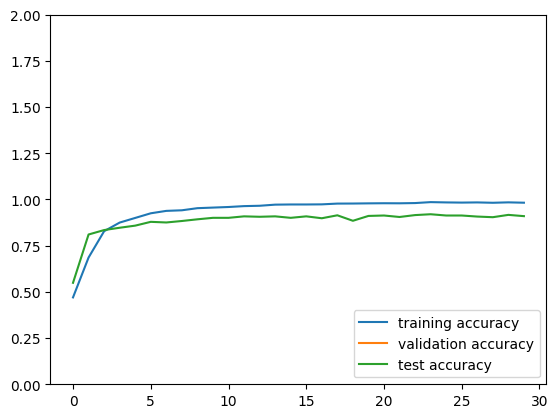

In [28]:
train_acc = [ np.array(x.cpu().float()) for x in train_acc ]
validation_acc = [ np.array(x.cpu().float()) for x in validation_acc ]
test_acc = [ np.array(x.cpu().float()) for x in test_acc ]


plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

In [29]:
dataset = pd.read_csv(f'{root}subtaskB_train.csv',  header=0,  names=['text', 'explicit_label', 'label'])
dataset = dataset.drop(columns=['explicit_label'])
dataset['text'] = dataset['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
dataset = add_hashtag(dataset)
dataset = shuffle(dataset, random_state=42)

(x_train_original_dataset, x_test_original_dataset, hashtag_train_original_dataset, hashtag_test_original_dataset,y_train_original_dataset, y_test_original_dataset) = train_test_split(dataset['text'], dataset['hashtag'] ,dataset['label'], test_size=0.2, random_state=42)

(x_train_original_dataset, x_val_original_dataset, hashtag_train_original_dataset, hashtag_val_original_dataset, y_train_original_dataset, y_val_original_dataset) = train_test_split( x_train_original_dataset,hashtag_train_original_dataset, y_train_original_dataset, test_size=0.1, random_state=42)

train_dataset_original_dataset = Dataset(x_train_original_dataset,hashtag_train_original_dataset, y_train_original_dataset, hyperparameters["stopwords"])
#val_dataset_original_dataset = Dataset(x_val_original_dataset,char_count_val_original_dataset,emoji_val_original_dataset,hashtag_val_original_dataset, y_val_original_dataset, hyperparameters["stopwords"])
test_dataset_original_dataset = Dataset(x_test_original_dataset,hashtag_test_original_dataset, y_test_original_dataset, hyperparameters["stopwords"])


model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)

#La funzione di loss va modificata in base al parametro #_classes
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])


train_loss_original_dataset, validation_loss_original_dataset,test_loss_original_dataset, train_acc_original_dataset, validation_acc_original_dataset, test_acc_original_dataset, best_acc, best_weights = train_test(
                                                model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset_original_dataset,
                                                test_dataset_original_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                criterion,
                                                None,
                                                None)
with open("best_weight_original.pkl", 'wb') as f:
  pickle.dump(best_weights, f)


Looking for hashtag:   0%|          | 0/810 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/583 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 6.1052  Test loss: 1.2382
Train accuracy: 0.3573  Test accuracy: 0.5123


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 6.2143  Test loss: 1.1608
Train accuracy: 0.5026  Test accuracy: 0.5123


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 4.1063  Test loss: 1.1189
Train accuracy: 0.5385  Test accuracy: 0.5123


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.9353  Test loss: 1.0652
Train accuracy: 0.5436  Test accuracy: 0.5123


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.8276  Test loss: 0.9722
Train accuracy: 0.5915  Test accuracy: 0.6173


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.7373  Test loss: 0.8927
Train accuracy: 0.6855  Test accuracy: 0.6420


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 4.1452  Test loss: 0.8457
Train accuracy: 0.7282  Test accuracy: 0.6667


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.5428  Test loss: 0.7782
Train accuracy: 0.7658  Test accuracy: 0.7531


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.9052  Test loss: 0.7429
Train accuracy: 0.8222  Test accuracy: 0.8210


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.3524  Test loss: 0.7120
Train accuracy: 0.8718  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.4331  Test loss: 0.6852
Train accuracy: 0.8906  Test accuracy: 0.8148


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.2154  Test loss: 0.6602
Train accuracy: 0.9145  Test accuracy: 0.8025


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.9411  Test loss: 0.6543
Train accuracy: 0.9299  Test accuracy: 0.8148


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.6142  Test loss: 0.6517
Train accuracy: 0.9470  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.8518  Test loss: 0.6374
Train accuracy: 0.9487  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.8312  Test loss: 0.6269
Train accuracy: 0.9692  Test accuracy: 0.7840


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.8253  Test loss: 0.6246
Train accuracy: 0.9778  Test accuracy: 0.8086


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.9460  Test loss: 0.6370
Train accuracy: 0.9744  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.2122  Test loss: 0.6298
Train accuracy: 0.9795  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.7176  Test loss: 0.6158
Train accuracy: 0.9846  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.0383  Test loss: 0.6468
Train accuracy: 0.9829  Test accuracy: 0.7654


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.2169  Test loss: 0.6410
Train accuracy: 0.9897  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.5441  Test loss: 0.6458
Train accuracy: 0.9915  Test accuracy: 0.7593


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.5281  Test loss: 0.6519
Train accuracy: 0.9880  Test accuracy: 0.7716


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.9883  Test loss: 0.6504
Train accuracy: 0.9915  Test accuracy: 0.7469


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.1615  Test loss: 0.6543
Train accuracy: 0.9949  Test accuracy: 0.7654


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.5263  Test loss: 0.6652
Train accuracy: 0.9949  Test accuracy: 0.7654


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.7406  Test loss: 0.6626
Train accuracy: 0.9949  Test accuracy: 0.7593


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.1693  Test loss: 0.6765
Train accuracy: 0.9932  Test accuracy: 0.7840


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.4135  Test loss: 0.6689
Train accuracy: 0.9983  Test accuracy: 0.7716


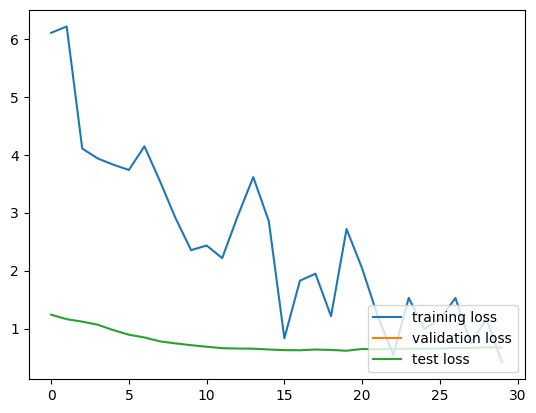

In [30]:
plt.plot(train_loss_original_dataset, label='training loss')
plt.plot(validation_loss_original_dataset, label='validation loss')
plt.plot(test_loss_original_dataset, label='test loss')
plt.legend(loc='lower right')
plt.show()

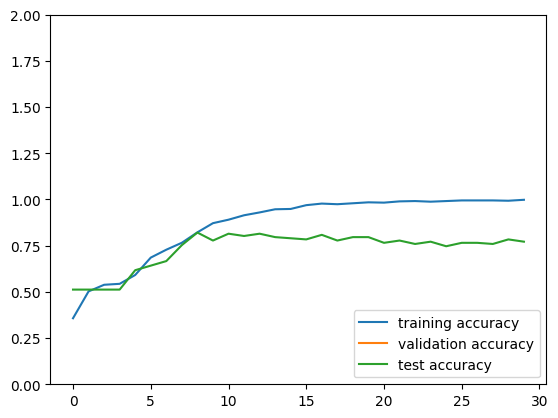

In [31]:
train_acc_original_dataset = [ np.array(x.cpu().float()) for x in train_acc_original_dataset ]
validation_acc_original_dataset = [ np.array(x.cpu().float()) for x in validation_acc_original_dataset ]
test_acc_original_dataset = [ np.array(x.cpu().float()) for x in test_acc_original_dataset ]

plt.plot(train_acc_original_dataset, label='training accuracy')
plt.plot(validation_acc_original_dataset, label='validation accuracy')
plt.plot(test_acc_original_dataset, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

In [ ]:
with open("best_weight_original.pkl", 'rb') as f:
  weights = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(hyperparameters["language_model"])


result_dataset = pd.DataFrame(columns=['Id', 'predicted_label'])
result_dataset.set_index('Id', inplace=True)


model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)
model.load_state_dict(weights)

model.eval()

test_set = pd.read_csv(f'{root}subtaskB_test.csv',  header=0, names=['id', 'text'])
test_set['text'] = test_set['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
test_set = add_hashtag(test_set)
test_set.drop(columns=['id'], inplace=True)

batch_size = 5

with torch.no_grad():
    for i in tqdm(range(0,len(test_set),batch_size)):
        tokens = tokenizer(list(test_set["text"].iloc[i:i+batch_size]), add_special_tokens=True,
                                   return_tensors='pt', padding='max_length',
                                   max_length = 512, truncation=True)
    
        tokens_hashtag = tokenizer(list(test_set["hashtag"].iloc[i:i+batch_size]), add_special_tokens=True,
                                return_tensors='pt', padding='max_length',
                                max_length = 32, truncation=True)
    
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
    
        input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
        mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)
    
        output = model(input_id_texts, mask_texts, input_id_hashtag)
        softmax = nn.LogSoftmax(dim=1)
        output = softmax(output).argmax(dim=1)
        
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()
        output = [int(i[0]) for i in output]
        current_results = pd.DataFrame({'predicted_label':output})
        
        result_dataset = pd.concat([result_dataset,current_results],ignore_index=True)


result_dataset.to_csv('results_original_datset.csv')
result_dataset.head()

In [ ]:
with open("best_weight.pkl", 'rb') as f:
  weights = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(hyperparameters["language_model"])


result_dataset = pd.DataFrame(columns=['Id', 'predicted_label'])
result_dataset.set_index('Id', inplace=True)


model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)
model.load_state_dict(weights)

model.eval()

test_set = pd.read_csv(f'{root}subtaskB_test.csv',  header=0, names=['id', 'text'])
test_set['text'] = test_set['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
test_set = add_hashtag(test_set)
test_set.drop(columns=['id'], inplace=True)

batch_size = 5

with torch.no_grad():
    for i in tqdm(range(0,len(test_set),batch_size)):
        tokens = tokenizer(list(test_set["text"].iloc[i:i+batch_size]), add_special_tokens=True,
                                   return_tensors='pt', padding='max_length',
                                   max_length = 512, truncation=True)
    
        
        tokens_hashtag = tokenizer(list(test_set["hashtag"].iloc[i:i+batch_size]), add_special_tokens=True,
                                return_tensors='pt', padding='max_length',
                                max_length = 32, truncation=True)
    
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
    
        input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
        mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)
    
        output = model(input_id_texts, mask_texts, input_id_hashtag)
        softmax = nn.LogSoftmax(dim=1)
        output = softmax(output).argmax(dim=1)
        
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()
        output = [int(i[0]) for i in output]
        current_results = pd.DataFrame({'predicted_label':output})
        
        result_dataset = pd.concat([result_dataset,current_results],ignore_index=True)


result_dataset.to_csv('results_augmented_datset.csv')
result_dataset.head()

La differenza tra le risposte è quantificabile controllando il numero di risposte che variano in base ai pesi, usando il sito [diffchecker](https://www.diffchecker.com/) è possibile dare in input i due testi e trovare le differenze tra loro.

Per il Task B, le risposte differenti tra i due pesi sono 56 su 300, per una variazione del 18,667% circa.